In [1]:
!pip install pareto

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pareto
import math

In [3]:
dataset = 'ft' # 'ml100k', 'ml1m', 'ft', 'anime'

## Frente de pareto

Load GridSearch results:

In [4]:
df = {}
for m in ['ResBeMF', 'BeMF', 'DirMF', 'PMF', 'MLP']:
    aux = pd.read_csv('results/gridsearch/' + dataset + '/' + m.lower() +'.csv')
    aux = aux[aux['cummulativemae_avg'] >= 0.05]
    aux = aux[aux['cummulativecoverage_avg'] >= 0.05]
    df[m] = aux

Plot the scatter:

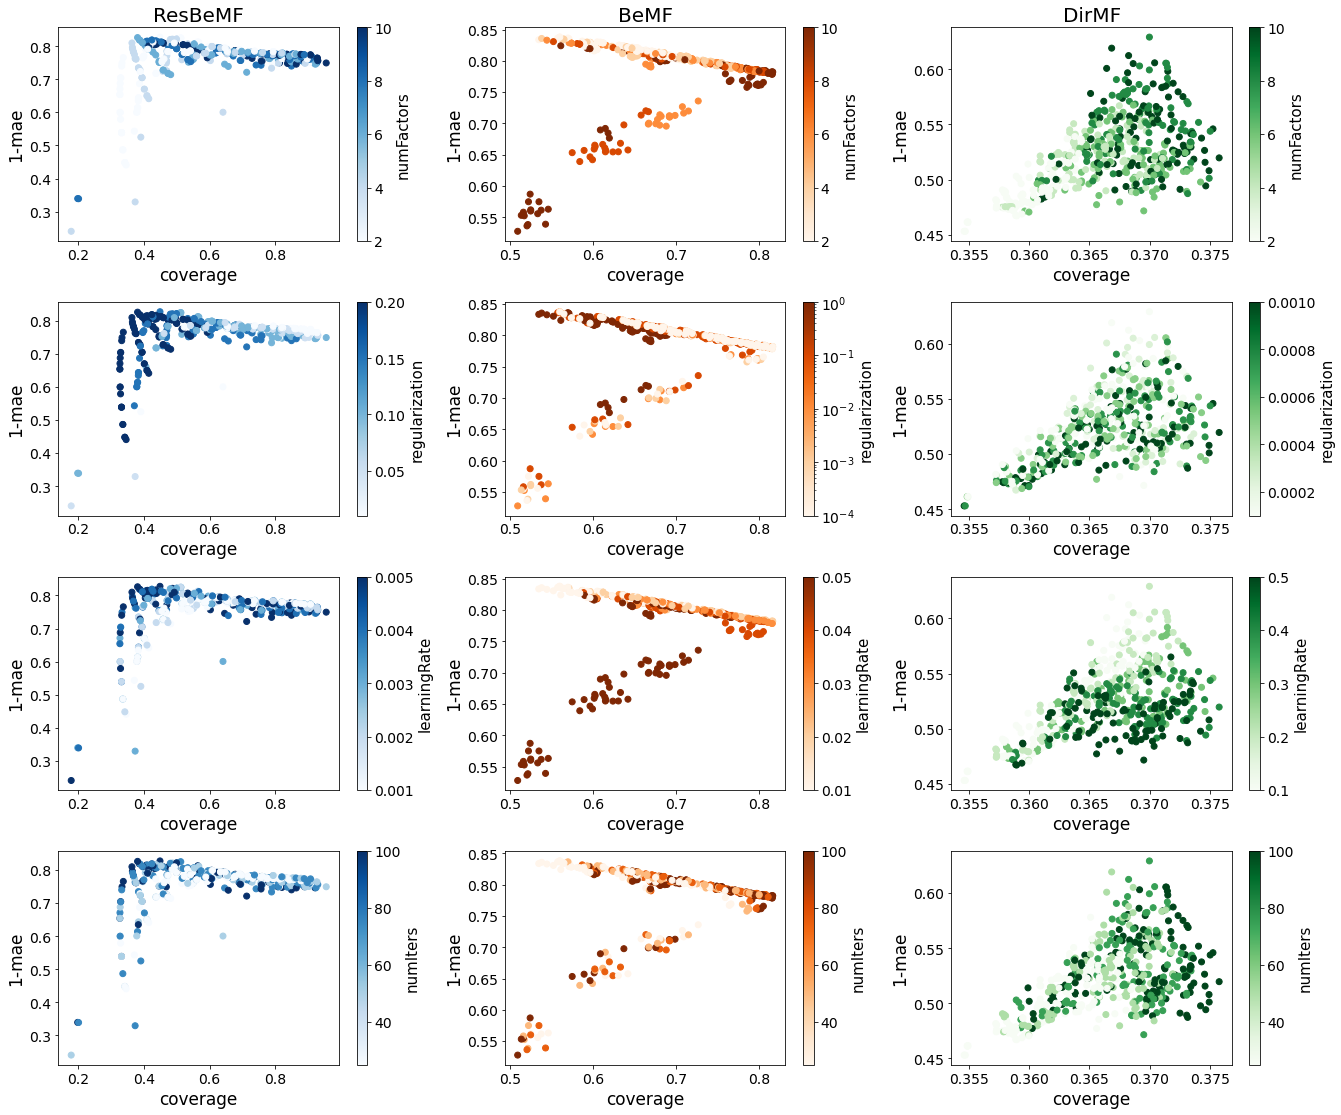

In [5]:
params = ['numFactors', 'regularization', 'learningRate', 'numIters']
methods = ['ResBeMF', 'BeMF', 'DirMF']
cmaps = ['Blues', 'Oranges', 'Greens']

fig, axs = plt.subplots(len(params), len(methods), figsize=(6*len(methods),3.75*len(params)))
fig.tight_layout(h_pad=4, w_pad=6.5)

for i, param in enumerate(params):
    for j, method in enumerate(methods):
        
        axs[i,j].set_xlabel('coverage', fontsize=17)
        axs[i,j].set_ylabel('1-mae', fontsize=17)
        
        if i == 0:
            axs[i,j].set_title(method, fontsize=20)
            
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)
            
        mae = df[method]['cummulativemae_avg']
        coverage = df[method]['cummulativecoverage_avg']
        color = df[method][param] 
                    
        norm = colors.LogNorm(vmin=color.min(), vmax=color.max()) if param == 'regularization' and (method == 'BeMF' or (method == 'ResBeMF' and dataset == 'anime')) else None
        
        im = axs[i,j].scatter(coverage, mae, c=color, cmap=cmaps[j], norm=norm)
        
        cbar = plt.colorbar(im, ax=axs[i,j])
        cbar.set_label(param, fontsize=15)
        cbar.ax.tick_params(labelsize=14)
        
plt.savefig('./figs/' + dataset + '-hyperparameters.png', dpi=300, bbox_inches='tight')

Plot the pareto fronts:

In [6]:
def get_pareto_front(df):
    objectives = [df.columns.get_loc(c) for c in ['cummulativemae_avg', 'cummulativecoverage_avg'] if c in df]
    nondominated = pareto.eps_sort([list(df.itertuples(False))], objectives, maximize_all=True)
    pareto_front = pd.DataFrame.from_records(nondominated, columns=list(df.columns.values))
    s = sorted(zip(pareto_front['cummulativecoverage_avg'], pareto_front['cummulativemae_avg']))
    cov, mae = [list(tuple) for tuple in zip(*s)]
    return cov, mae

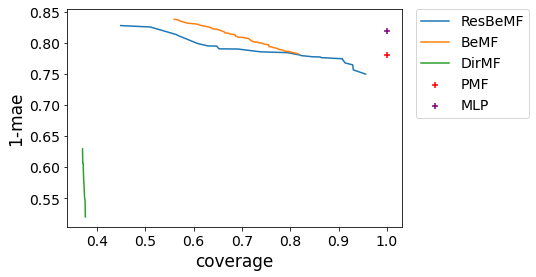

In [7]:
resbemf_coverage, resbemf_mae = get_pareto_front(df['ResBeMF'])
plt.plot(resbemf_coverage, resbemf_mae, label='ResBeMF')

bemf_coverage, bemf_mae = get_pareto_front(df['BeMF'])
plt.plot(bemf_coverage, bemf_mae, label='BeMF')

dirmf_coverage, dirmf_mae = get_pareto_front(df['DirMF'])
plt.plot(dirmf_coverage, dirmf_mae, label='DirMF')

pmf_coverage, pmf_mae = get_pareto_front(df['PMF'])
plt.scatter(pmf_coverage, pmf_mae, label='PMF', c='red', marker='+')

mlp_coverage, mlp_mae = get_pareto_front(df['MLP'])
plt.scatter(mlp_coverage, mlp_mae, label='MLP', c='purple', marker='+')

plt.xlabel('coverage', fontsize=17)
plt.xticks(fontsize=14)

plt.ylabel('1-mae', fontsize=17)
plt.yticks(fontsize=14)
    
plt.legend(fontsize=14, loc=(1.04, 0.5))

plt.savefig('./figs/' + dataset + '-pareto-front.png', dpi=300, bbox_inches='tight')

## Test split error

Load test split results:

In [8]:
mae_df = pd.read_csv('results/test-split/' + dataset + '/mae.csv')
mae_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,DirMF_6,DirMF_7,DirMF_8,DirMF_9,DirMF_10,DirMF_11,DirMF_12,DirMF_13,PMF,MLP
0,0.00,0.763592,0.768070,0.757533,0.782340,0.714286,0.753223,0.759018,0.714286,0.769105,...,0.787775,0.795001,0.793971,0.795956,0.787818,0.800181,0.786401,0.784992,0.768908,0.793416
1,0.05,0.763592,0.768070,0.757533,0.782340,0.714286,0.753223,0.759018,0.714286,0.769105,...,0.787775,0.795001,0.793971,0.795956,0.787818,0.800181,0.786401,0.784992,0.768908,0.793416
2,0.15,0.764011,0.768596,0.757567,0.782621,0.714286,0.753290,0.759018,0.714286,0.769845,...,0.795074,0.802707,0.800005,0.802536,0.789641,0.804214,0.795850,0.793379,0.768908,0.793416
3,0.20,0.769630,0.775539,0.764796,0.800389,0.714286,0.758651,0.759032,0.714286,0.781188,...,0.821629,0.826446,0.817388,0.821235,0.831706,0.815331,0.831956,0.826685,0.768908,0.793416
4,0.25,0.777975,0.781611,0.770062,0.815665,0.714286,0.764404,0.766320,0.714286,0.784127,...,0.875279,0.861599,0.852663,0.848179,0.859469,0.842857,0.832288,0.858197,0.768908,0.793416
5,0.30,0.782195,0.785540,0.775930,0.830909,0.714286,0.768764,0.770444,0.714286,0.791819,...,0.923077,0.804762,0.828157,0.895604,0.791667,0.702381,0.886905,0.897959,0.768908,0.793416
6,0.35,0.779071,0.788276,0.779594,0.838353,1.000000,0.775179,0.780299,1.000000,0.802418,...,1.000000,1.000000,0.500000,1.000000,0.678571,1.000000,1.000000,1.000000,0.768908,0.793416
7,0.40,0.785014,0.787702,0.783155,0.846945,1.000000,0.777184,0.788408,1.000000,0.816416,...,1.000000,1.000000,0.285714,1.000000,1.000000,1.000000,1.000000,1.000000,0.768908,0.793416
8,0.45,0.785269,0.816238,0.797693,0.907732,1.000000,0.783434,0.791901,1.000000,0.846604,...,1.000000,1.000000,0.285714,1.000000,1.000000,1.000000,1.000000,1.000000,0.768908,0.793416
9,0.50,0.790385,0.831202,0.797519,0.899007,1.000000,0.786419,0.794690,1.000000,0.870279,...,1.000000,1.000000,0.285714,1.000000,1.000000,1.000000,1.000000,1.000000,0.768908,0.793416


In [9]:
coverage_df = pd.read_csv('results/test-split/' + dataset + '/coverage.csv')
coverage_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,DirMF_6,DirMF_7,DirMF_8,DirMF_9,DirMF_10,DirMF_11,DirMF_12,DirMF_13,PMF,MLP
0,0.00,1.000000,1.000000,1.000000,1.000000,0.002381,1.000000,1.000000,0.002381,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
1,0.05,1.000000,1.000000,1.000000,1.000000,0.002381,1.000000,1.000000,0.002381,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1
2,0.15,0.997852,0.996593,0.999923,0.986877,0.002381,0.999860,1.000000,0.002381,0.993566,...,0.920499,0.908507,0.917602,0.928688,0.923579,0.928129,0.917580,0.913426,1,1
3,0.20,0.943181,0.950465,0.956622,0.772822,0.002381,0.971226,0.985257,0.002381,0.927562,...,0.415076,0.377489,0.411430,0.420713,0.417317,0.406498,0.426602,0.413844,1,1
4,0.25,0.897394,0.887248,0.899251,0.481149,0.002381,0.927298,0.928626,0.002381,0.806616,...,0.075835,0.083663,0.074573,0.086060,0.097027,0.077554,0.109016,0.087151,1,1
5,0.30,0.856276,0.815998,0.811090,0.323741,0.002381,0.885672,0.837845,0.002381,0.622156,...,0.005546,0.007296,0.010890,0.003563,0.005247,0.002681,0.009946,0.009888,1,1
6,0.35,0.771888,0.653556,0.698905,0.191025,0.000000,0.810098,0.723118,0.000000,0.433315,...,0.000132,0.000000,0.001850,0.000428,0.000706,0.000000,0.000132,0.000132,1,1
7,0.40,0.673367,0.480228,0.610742,0.129313,0.000000,0.716630,0.625497,0.000000,0.289116,...,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
8,0.45,0.581506,0.311545,0.520954,0.085199,0.000000,0.633842,0.531478,0.000000,0.161420,...,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
9,0.50,0.484531,0.198291,0.437471,0.048544,0.000000,0.543328,0.449098,0.000000,0.078561,...,0.000000,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,1,1


In [10]:
accuracy_df = pd.read_csv('results/test-split/' + dataset + '/accuracy.csv')
accuracy_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,DirMF_4,DirMF_5,DirMF_6,DirMF_7,DirMF_8,DirMF_9,DirMF_10,DirMF_11,DirMF_12,DirMF_13
0,0.00,0.309797,0.317920,0.300606,0.337716,0,0.302311,0.300138,0,0.319414,...,0.294276,0.333944,0.320866,0.325769,0.314727,0.318770,0.308498,0.345463,0.302039,0.319165
1,0.05,0.309797,0.317920,0.300606,0.337716,0,0.302311,0.300138,0,0.319414,...,0.294276,0.333944,0.320866,0.325769,0.314727,0.318770,0.308498,0.345463,0.302039,0.319165
2,0.15,0.311083,0.319414,0.300621,0.338588,0,0.302337,0.300138,0,0.320504,...,0.303164,0.341334,0.328419,0.334303,0.323236,0.328116,0.312239,0.351070,0.311883,0.326747
3,0.20,0.316594,0.325206,0.310432,0.367384,0,0.310594,0.301044,0,0.330558,...,0.381891,0.378607,0.369827,0.381622,0.368682,0.361291,0.383857,0.387331,0.364018,0.382401
4,0.25,0.326042,0.332318,0.313038,0.419770,0,0.314865,0.309187,0,0.345181,...,0.430752,0.455454,0.483401,0.489005,0.411911,0.444076,0.462723,0.473016,0.420840,0.500283
5,0.30,0.333108,0.341549,0.324135,0.473198,0,0.316619,0.318248,0,0.359543,...,0.261905,0.500000,0.538462,0.433333,0.536232,0.576923,0.458333,0.333333,0.558333,0.500000
6,0.35,0.328584,0.351630,0.335049,0.534961,0,0.325281,0.341699,0,0.384029,...,0.000000,0.000000,1.000000,0.000000,0.166667,1.000000,0.250000,0.000000,1.000000,1.000000
7,0.40,0.347070,0.365295,0.348336,0.603187,0,0.335880,0.355518,0,0.437818,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.45,0.348271,0.445834,0.374252,0.681222,0,0.348009,0.365990,0,0.504017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.50,0.355534,0.481726,0.381428,0.681814,0,0.369712,0.375558,0,0.609063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
ndcg_df = pd.read_csv('results/test-split/' + dataset + '/ndcg.csv')
ndcg_df

,reliability,ResBeMF_0,ResBeMF_1,ResBeMF_2,ResBeMF_3,ResBeMF_4,ResBeMF_5,ResBeMF_6,ResBeMF_7,ResBeMF_8,...,DirMF_6,DirMF_7,DirMF_8,DirMF_9,DirMF_10,DirMF_11,DirMF_12,DirMF_13,PMF,MLP
0,0.00,0.889699,0.888040,0.888789,0.882713,0.002381,0.886707,0.887950,0.002381,0.888884,...,0.892754,0.892271,0.884689,0.890049,0.891937,0.893911,0.888912,0.887845,0.90882,0.90882
1,0.05,0.889699,0.888040,0.888789,0.882713,0.002381,0.886707,0.887950,0.002381,0.888884,...,0.892754,0.892271,0.884689,0.890049,0.891937,0.893911,0.888912,0.887845,0.90882,0.90882
2,0.15,0.888759,0.886701,0.888789,0.877267,0.002381,0.886707,0.887950,0.002381,0.886141,...,0.862729,0.855094,0.850081,0.866043,0.862504,0.866069,0.861364,0.855838,0.90882,0.90882
3,0.20,0.853862,0.857889,0.862020,0.726085,0.002381,0.866982,0.879364,0.002381,0.847887,...,0.480077,0.443465,0.476016,0.485791,0.481220,0.463643,0.494399,0.476381,0.90882,0.90882
4,0.25,0.824235,0.814942,0.832797,0.477381,0.002381,0.839473,0.850727,0.002381,0.770410,...,0.108855,0.117109,0.108850,0.124985,0.134434,0.106732,0.137142,0.121041,0.90882,0.90882
5,0.30,0.803079,0.766993,0.786628,0.337805,0.002381,0.817967,0.809384,0.002381,0.633627,...,0.010150,0.011141,0.018225,0.007701,0.008432,0.006990,0.016088,0.014183,0.90882,0.90882
6,0.35,0.751821,0.642322,0.724785,0.203104,0.000000,0.779986,0.741342,0.000000,0.465024,...,0.000524,0.000000,0.002939,0.001326,0.001750,0.000000,0.000524,0.000524,0.90882,0.90882
7,0.40,0.690221,0.497076,0.660132,0.140355,0.000000,0.722890,0.668772,0.000000,0.324312,...,0.000000,0.000000,0.000703,0.000000,0.000000,0.000000,0.000000,0.000000,0.90882,0.90882
8,0.45,0.623833,0.328845,0.583231,0.095739,0.000000,0.668512,0.586779,0.000000,0.188046,...,0.000000,0.000000,0.000703,0.000000,0.000000,0.000000,0.000000,0.000000,0.90882,0.90882
9,0.50,0.540414,0.217893,0.498694,0.056412,0.000000,0.591421,0.500353,0.000000,0.094157,...,0.000000,0.000000,0.000703,0.000000,0.000000,0.000000,0.000000,0.000000,0.90882,0.90882


Remove values computed with a coverage less than 0.01:

In [12]:
for c in coverage_df.columns.tolist()[1:]:
    for i in range(coverage_df['reliability'].size):
        if coverage_df[c][i] <= 0.01:
            mae_df[c][i] = math.nan
            accuracy_df[c][i] = math.nan
            ndcg_df[c][i] = math.nan

<ipython-input-12-659dfddc6eb7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_df[c][i] = math.nan
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Compute aveage error and its std:

In [13]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    mae_df[method + "_mean"] = mae_df.loc[:, mae_df.columns.str.startswith(method)].mean(axis=1)
    mae_df[method + "_std"] = mae_df.loc[:, mae_df.columns.str.startswith(method)].std(axis=1)

In [14]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    coverage_df[method + "_mean"] = coverage_df.loc[:, coverage_df.columns.str.startswith(method)].mean(axis=1)
    coverage_df[method + "_std"] = coverage_df.loc[:, coverage_df.columns.str.startswith(method)].std(axis=1)

In [15]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    accuracy_df[method + "_mean"] = accuracy_df.loc[:, accuracy_df.columns.str.startswith(method)].mean(axis=1)
    accuracy_df[method + "_std"] = accuracy_df.loc[:, accuracy_df.columns.str.startswith(method)].std(axis=1)

In [16]:
for method in ["ResBeMF", "BeMF", "DirMF"]:
    ndcg_df[method + "_mean"] = ndcg_df.loc[:, ndcg_df.columns.str.startswith(method)].mean(axis=1)
    ndcg_df[method + "_std"] = ndcg_df.loc[:, ndcg_df.columns.str.startswith(method)].std(axis=1)

Plot the figure:

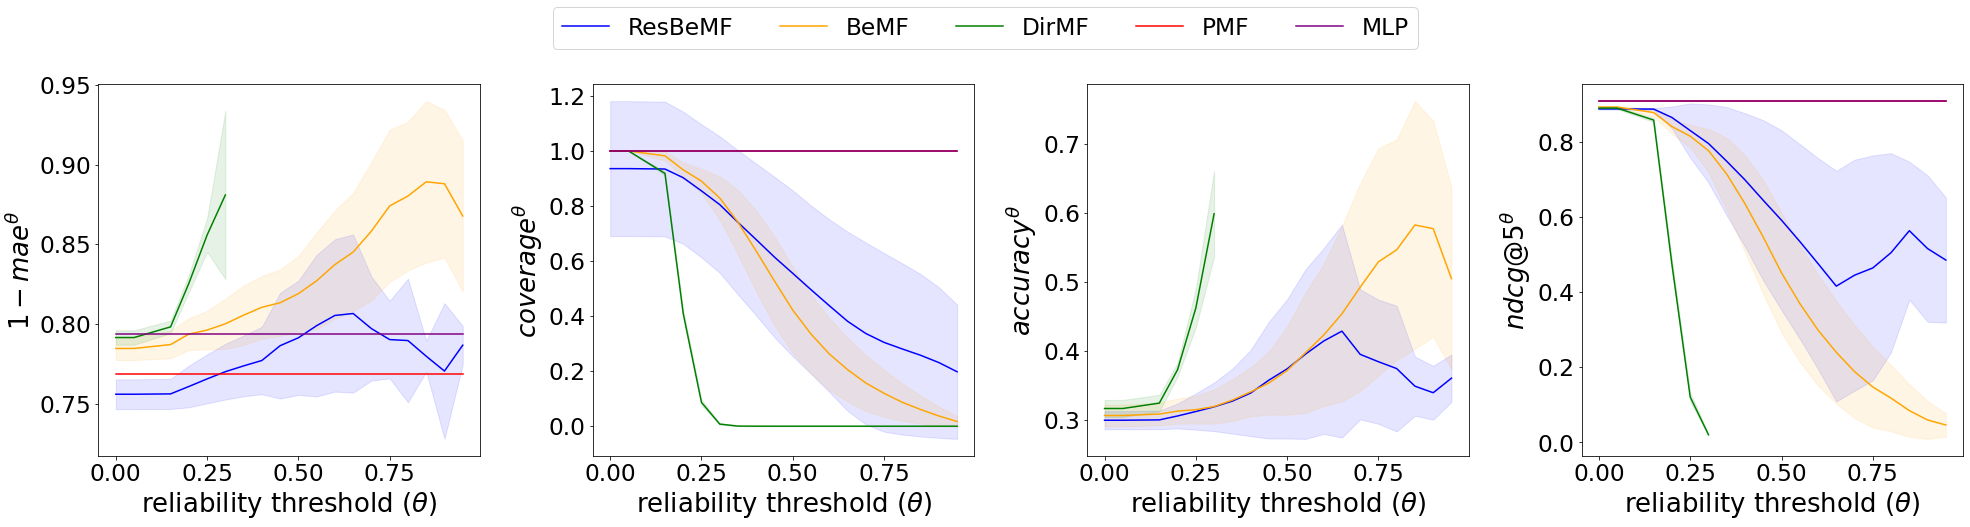

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(28,7))

fontsize = 26

# mae

axs[0].set_xlabel(r'reliability threshold ($\theta$)', fontsize=fontsize)
axs[0].set_ylabel('$1-mae^θ$', fontsize=fontsize)

axs[0].tick_params(axis='both', which='major', labelsize=0.9*fontsize)

axs[0].fill_between(mae_df['reliability'], mae_df['ResBeMF_mean'] + mae_df['ResBeMF_std'], mae_df['ResBeMF_mean'] - mae_df['ResBeMF_std'], color='blue', alpha=0.1)
resbemf_line, = axs[0].plot(mae_df['reliability'], mae_df['ResBeMF_mean'], c='blue')

axs[0].fill_between(mae_df['reliability'], mae_df['BeMF_mean'] + mae_df['BeMF_std'], mae_df['BeMF_mean'] - mae_df['BeMF_std'], color='orange', alpha=0.1)
bemf_line, = axs[0].plot(mae_df['reliability'], mae_df['BeMF_mean'], c='orange')

axs[0].fill_between(mae_df['reliability'], mae_df['DirMF_mean'] + mae_df['DirMF_std'], mae_df['DirMF_mean'] - mae_df['DirMF_std'], color='green', alpha=0.1)
dirmf_line, = axs[0].plot(mae_df['reliability'], mae_df['DirMF_mean'], c='green')

pmf_line, = axs[0].plot(mae_df['reliability'], mae_df['PMF'], c='red')

mlp_line, = axs[0].plot(mae_df['reliability'], mae_df['MLP'], c='purple')


# coverage

axs[1].set_xlabel(r'reliability threshold ($\theta$)', fontsize=fontsize)
axs[1].set_ylabel('$coverage^θ$', fontsize=fontsize)

axs[1].tick_params(axis='both', which='major', labelsize=0.9*fontsize)

axs[1].fill_between(coverage_df['reliability'], coverage_df['ResBeMF_mean'] + coverage_df['ResBeMF_std'], coverage_df['ResBeMF_mean'] - coverage_df['ResBeMF_std'], color='blue', alpha=0.1)
axs[1].plot(coverage_df['reliability'], coverage_df['ResBeMF_mean'], c='blue')

axs[1].fill_between(coverage_df['reliability'], coverage_df['BeMF_mean'] + coverage_df['BeMF_std'], coverage_df['BeMF_mean'] - coverage_df['BeMF_std'], color='orange', alpha=0.1)
axs[1].plot(coverage_df['reliability'], coverage_df['BeMF_mean'], c='orange')

axs[1].fill_between(coverage_df['reliability'], coverage_df['DirMF_mean'] + coverage_df['DirMF_std'], coverage_df['DirMF_mean'] - coverage_df['DirMF_std'], color='green', alpha=0.1)
axs[1].plot(coverage_df['reliability'], coverage_df['DirMF_mean'], c='green')

axs[1].plot(coverage_df['reliability'], coverage_df['PMF'], c='red')

axs[1].plot(coverage_df['reliability'], coverage_df['MLP'], c='purple')


# accuracy

axs[2].set_xlabel(r'reliability threshold ($\theta$)', fontsize=fontsize)
axs[2].set_ylabel('$accuracy^θ$', fontsize=fontsize)

axs[2].tick_params(axis='both', which='major', labelsize=0.9*fontsize)

axs[2].fill_between(accuracy_df['reliability'], accuracy_df['ResBeMF_mean'] + accuracy_df['ResBeMF_std'], accuracy_df['ResBeMF_mean'] - accuracy_df['ResBeMF_std'], color='blue', alpha=0.1)
axs[2].plot(accuracy_df['reliability'], accuracy_df['ResBeMF_mean'], c='blue')

axs[2].fill_between(accuracy_df['reliability'], accuracy_df['BeMF_mean'] + accuracy_df['BeMF_std'], accuracy_df['BeMF_mean'] - accuracy_df['BeMF_std'], color='orange', alpha=0.1)
axs[2].plot(accuracy_df['reliability'], accuracy_df['BeMF_mean'], c='orange')

axs[2].fill_between(accuracy_df['reliability'], accuracy_df['DirMF_mean'] + accuracy_df['DirMF_std'], accuracy_df['DirMF_mean'] - accuracy_df['DirMF_std'], color='green', alpha=0.1)
axs[2].plot(accuracy_df['reliability'], accuracy_df['DirMF_mean'], c='green')


# ndcg

axs[3].set_xlabel(r'reliability threshold ($\theta$)', fontsize=fontsize)
axs[3].set_ylabel('$ndcg@5^θ$', fontsize=fontsize)

axs[3].tick_params(axis='both', which='major', labelsize=0.9*fontsize)

axs[3].fill_between(ndcg_df['reliability'], ndcg_df['ResBeMF_mean'] + ndcg_df['ResBeMF_std'], ndcg_df['ResBeMF_mean'] - ndcg_df['ResBeMF_std'], color='blue', alpha=0.1)
axs[3].plot(ndcg_df['reliability'], ndcg_df['ResBeMF_mean'], c='blue')

axs[3].fill_between(ndcg_df['reliability'], ndcg_df['BeMF_mean'] + ndcg_df['BeMF_std'], ndcg_df['BeMF_mean'] - ndcg_df['BeMF_std'], color='orange', alpha=0.1)
axs[3].plot(ndcg_df['reliability'], ndcg_df['BeMF_mean'], c='orange')

axs[3].fill_between(ndcg_df['reliability'], ndcg_df['DirMF_mean'] + ndcg_df['DirMF_std'], ndcg_df['DirMF_mean'] - ndcg_df['DirMF_std'], color='green', alpha=0.1)
axs[3].plot(ndcg_df['reliability'], ndcg_df['DirMF_mean'], c='green')

axs[3].plot(ndcg_df['reliability'], ndcg_df['PMF'], c='red')

axs[3].plot(ndcg_df['reliability'], ndcg_df['MLP'], c='purple')

# legend

lines = [resbemf_line, bemf_line, dirmf_line, pmf_line, mlp_line]
labels = ["ResBeMF", "BeMF", "DirMF", "PMF", "MLP"]
plt.figlegend(lines, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.1), fontsize=0.9*fontsize)

plt.tight_layout(pad=3)

plt.savefig('./figs/' + dataset + '-test-error.png', dpi=300, bbox_inches='tight')